In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torchvision import models, transforms
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz
from PIL import Image
from sklearn.metrics import confusion_matrix
from train_checkpoint import get_starter_dataset
from util.util import calculate_accuracy,compute_losses,simple_mia,standard_mia,plot_confusion_matrix
from torchvision.models import resnet18
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
retain_loader, forget_loader, val_loader,test_loader,train_loader = get_starter_dataset(2,2,2)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
n_class = 10
net = resnet18(weights=None, num_classes=n_class)
net.load_state_dict(torch.load('checkpoints/pre-train-model_epoch_40_lr_0.1_momentum_0.9_weightdecay_0.0005.pth'))
net.to(DEVICE);
# print(f"Pre-trained performance, Retain_loader Accuracy: {calculate_accuracy(net,retain_loader):.2f}%, forget_loader Accuracy: {calculate_accuracy(net,forget_loader):.2f}%, Test_loader Accuracy: {calculate_accuracy(net,test_loader):.2f}%")
# print("Pre-trained Standard MIA {:.2f}".format(standard_mia(net,forget_loader,test_loader)))

In [6]:
import torch
from torchvision import models, transforms
import captum
import matplotlib.pyplot as plt
from captum.attr import LayerGradCam
import numpy as np
# Assuming 'data_loader' is your DataLoader instance and 'model' is your trained model
net.to('cpu');
# Load an image from forget_loader
# 


Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


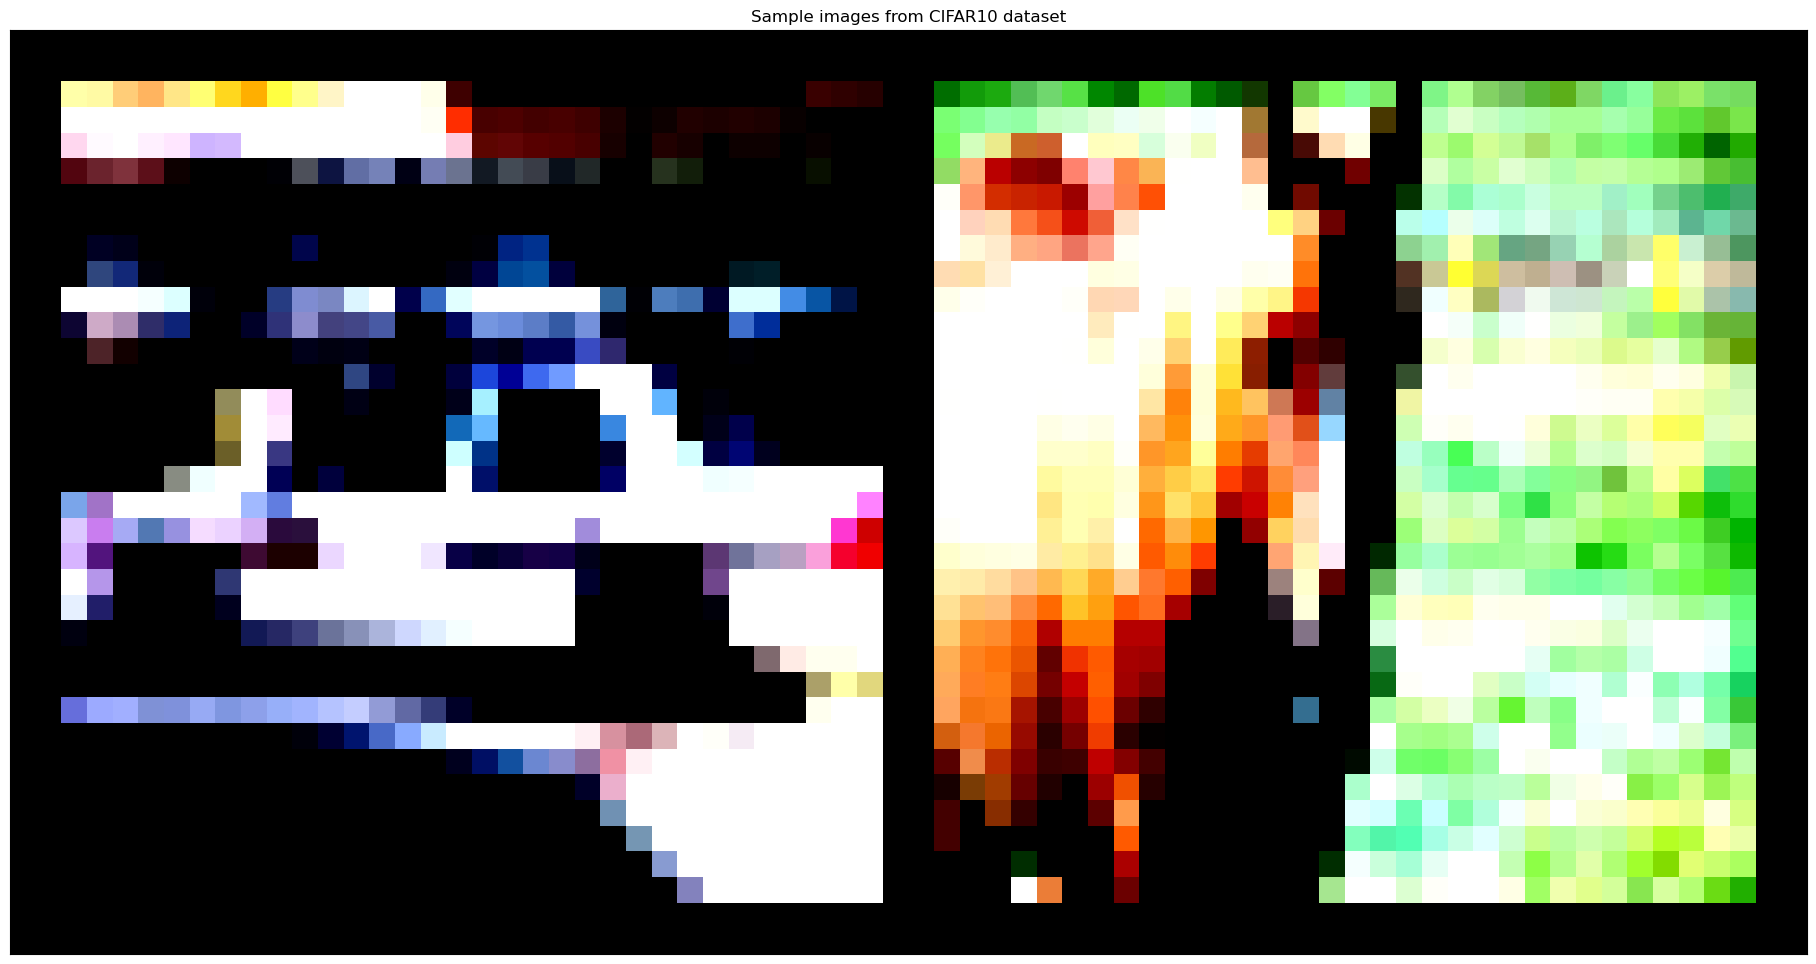

In [47]:
# a temporary data loader without normalization, just to show the images
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18
tmp_dl = DataLoader(
    torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transforms.ToTensor()
    ),
    batch_size=16 * 5,
    shuffle=False,
)
images, labels = next(iter(retain_loader))

fig, ax = plt.subplots(figsize=(25, 12))
plt.title("Sample images from CIFAR10 dataset")
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
plt.show()

In [55]:
retain_loader, forget_loader, val_loader,test_loader,train_loader = get_starter_dataset(1,1,1)
def unnormalize(tensor):
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    tensor = tensor.clone()  # clone to avoid modifying in-place
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # multiply by std and add mean
    return tensor

# Get a batch of images and reverse normalization
images, _ = next(iter(forget_loader))
unnormalized_images = torch.stack([unnormalize(img) for img in images])


Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


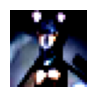

In [65]:
plt.figure(figsize=(1, 1))
plt.imshow(make_grid(images, nrow=4).permute(1, 2, 0))
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


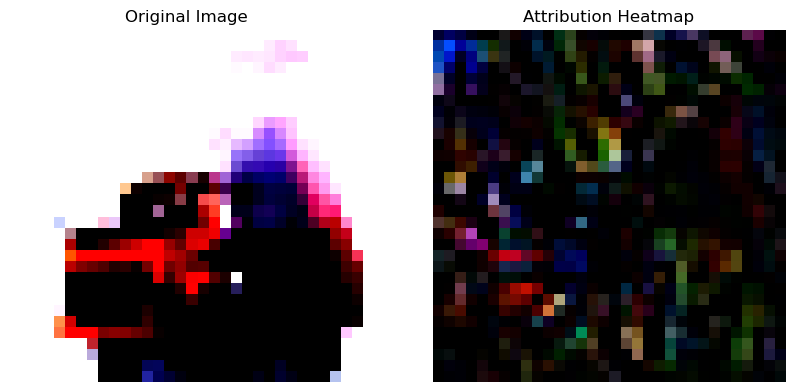

<Figure size 100x100 with 0 Axes>

In [74]:
import torch
import torchvision.models as models
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'forget_loader' is your DataLoader
# input_batch, _ = next(iter(forget_loader))  # Get a batch of images
input_batch, _ = next(iter(forget_loader))  # Assuming forget_loader is available

# Load a pre-trained ResNet-18 model
net.eval()

# Select the first image from the batch
img_tensor = input_batch[0].unsqueeze(0)  # Add batch dimension

# Ensure tensor is on the same device as the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
img_tensor = img_tensor.to('cuda')
net = net.to('cuda')

# Initialize Integrated Gradients
integrated_gradients = IntegratedGradients(net)

# Compute the attribution of the prediction to the input
# Here, target=0 refers to the index of the output for which gradients are computed.
# For a specific class, change target to the index of that class.
attributions_ig = integrated_gradients.attribute(img_tensor, target=0)

# Process the attribution for visualization
attributions_ig = attributions_ig.cpu().detach().numpy().squeeze()

# Convert the attribution to a positive value and then normalize
attributions_ig = np.maximum(attributions_ig, 0)
attributions_ig = attributions_ig / np.max(attributions_ig)

# Visualize the image and its attribution
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Original image
axs[0].imshow(np.transpose(input_batch[0].cpu().numpy(), (1, 2, 0)))
axs[0].axis('off')
axs[0].set_title('Original Image')

# Attribution heatmap
axs[1].imshow(np.transpose(attributions_ig, (1, 2, 0)))
axs[1].axis('off')
axs[1].set_title('Attribution Heatmap')
plt.figure(figsize=(1, 1))
plt.tight_layout()
plt.show()